# Histopathologic Cancer Detection with CNN

#### *In this project, we developed a Convolutional Neural Network (CNN) model to detect cancerous tissues from histopathological images. Using the Histopathologic Cancer Detection dataset from Kaggle, which contains labeled images of tissue samples, our goal was to build a robust binary classification model that can distinguish between cancerous and non-cancerous tissues. The project involved preprocessing the images, optimizing the model architecture with techniques such as batch normalization and dropout, and fine-tuning hyperparameters to achieve high accuracy.*

#### The dataset can be found here: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

In [84]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Data

#### Loading Kaggle data with Kaggle API key

In [1]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irinatilak","key":"175bd9e5d584452eb53ed105c8ea0899"}'}

In [2]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [01:32<00:00, 171MB/s]
100% 6.31G/6.31G [01:32<00:00, 73.5MB/s]


In [4]:
import zipfile

zip_path = "histopathologic-cancer-detection.zip"
output_dir = "cancer_detection_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [5]:
train_folder = os.path.join(output_dir, "train")

image_files = os.listdir(train_folder)

In [6]:
img_path = os.path.join(train_folder, image_files[0])
img_train = Image.open(img_path)

# 2. EDA

#### Displaying 20 randomly selected images

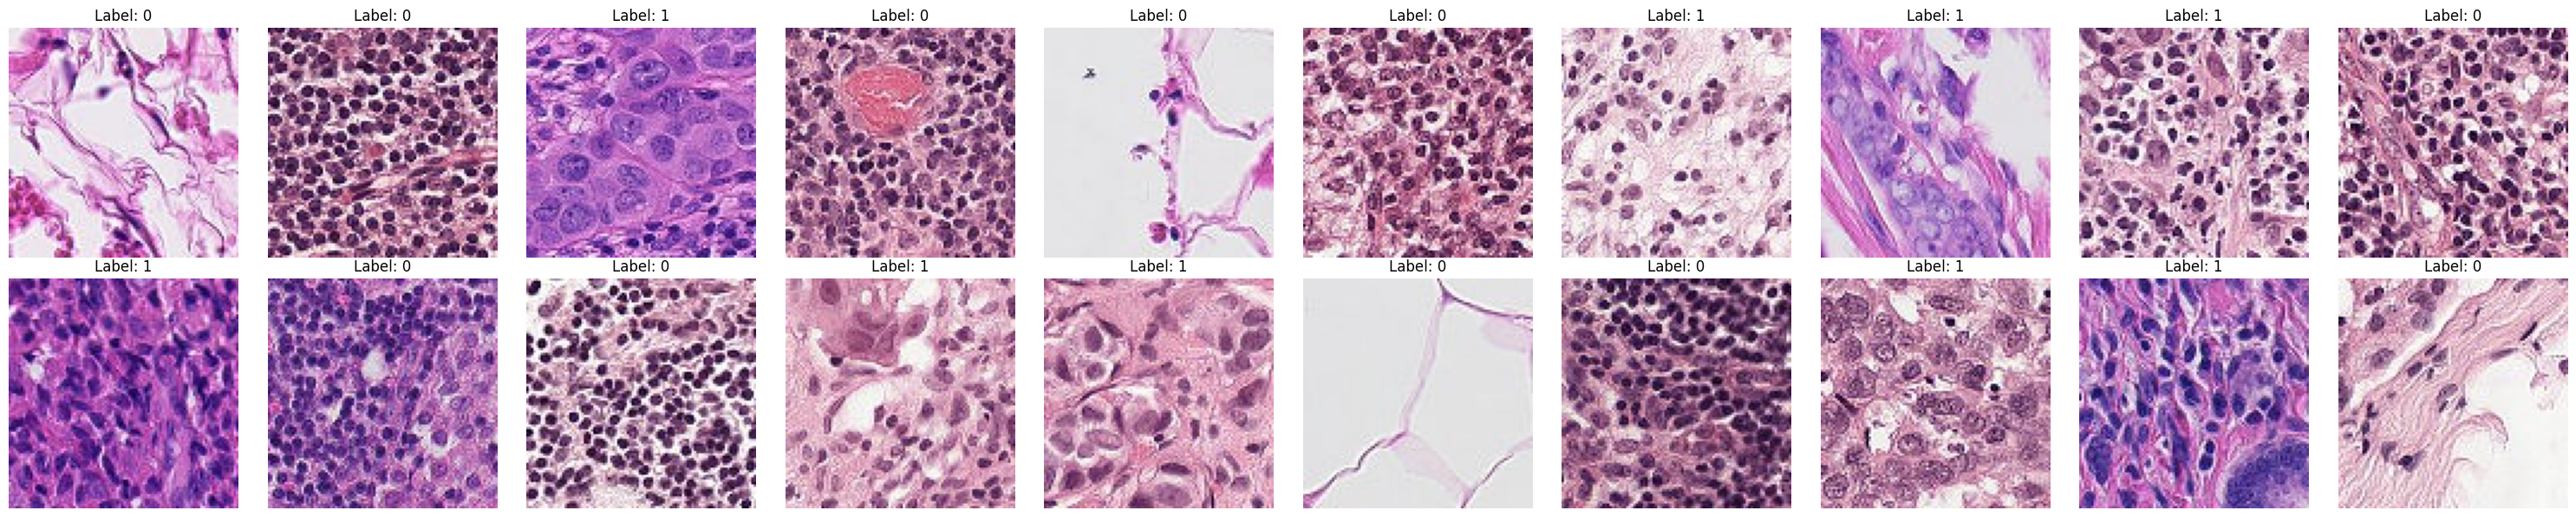

In [86]:
labels_csv = "cancer_detection_dataset/train_labels.csv"

labels_df = pd.read_csv(labels_csv)

labels_df['file_path'] = labels_df['id'].apply(lambda x: os.path.join(train_folder, f"{x}.tif"))

image_file_sample = labels_df.sample(20, random_state=100)

plt.figure(figsize=(30, 6))
for i, row in enumerate(image_file_sample.itertuples(), start=1):
    img_path = row.file_path
    label = row.label

    img = Image.open(img_path)

    ax = plt.subplot(2, 10, i)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Checking images format consistency

In [10]:
formats = []

for filename in os.listdir(train_folder):
    file_path = os.path.join(train_folder, img_file)
    try:
        with Image.open(file_path) as img:
            formats.append({'File': filename, 'Format': img.format})
    except Exception as e:
        formats.append({'File': filename, 'Format': 'Error'})

df_image_format = pd.DataFrame(formats)


In [11]:
df_image_format.head()

,File,Format
0,18768dab4bd3ed1272f19ded2e79f4502301ca4c.tif,TIFF
1,8289133ea29aa371ffb5c71cb510694cc9305ce2.tif,TIFF
2,e04aea8404b7183fb310d72da447706e053085ae.tif,TIFF
3,e272d4321aae0970137a7ff5f62624e7b283e70f.tif,TIFF
4,056a35c220f4faea29602617a770789bb7efa9be.tif,TIFF


In [12]:
df_image_format['Format'].unique()

array(['TIFF'], dtype=object)

#### Image Size

In [13]:
image_sizes = []

# Process each image
for img_file in image_files:
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append({'Image': os.path.basename(img_file), 'Width': width, 'Height': height})

# Create a DataFrame
df_image_size = pd.DataFrame(image_sizes)

In [14]:
df_image_size.head()

,Image,Width,Height
0,18768dab4bd3ed1272f19ded2e79f4502301ca4c.tif,96,96
1,8289133ea29aa371ffb5c71cb510694cc9305ce2.tif,96,96
2,e04aea8404b7183fb310d72da447706e053085ae.tif,96,96
3,e272d4321aae0970137a7ff5f62624e7b283e70f.tif,96,96
4,056a35c220f4faea29602617a770789bb7efa9be.tif,96,96


In [15]:
df_image_size['Width'].unique(), df_image_size['Height'].unique()

(array([96]), array([96]))

#### Labels distribution in the train set - Benign (0) vs Malignant (1)

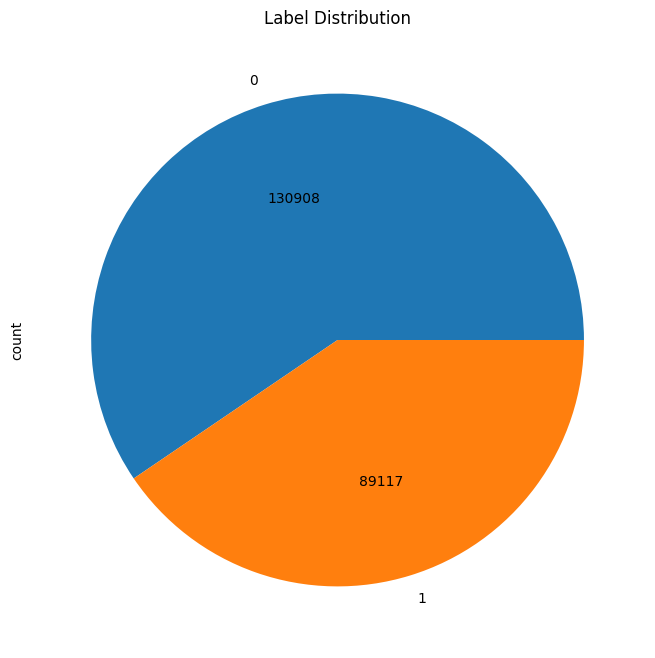

In [92]:
def autopct_counts(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))  # Calculate the count
    return f'{absolute}'

value_counts = labels_df['label'].value_counts()
labels_df['label'].value_counts().plot(
    kind='pie',
    autopct=lambda pct: autopct_counts(pct, value_counts),
    legend=False,
    figsize=(8, 8),
    title="Label Distribution"
)

plt.show()

#### Any missing values?

In [93]:
missing_values = labels_df.isnull().sum()
missing_values

,0
id,0
label,0
file_path,0


# 3. Data Processing

#### Converting .tiff images into .png format. This will help us save storage space and reduce loading times during training without sacrificing quality

In [16]:
input_folder = "cancer_detection_dataset/train"
output_folder = "path_to_converted_images"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith(".tiff") or filename.endswith(".tif"):
        img = Image.open(os.path.join(input_folder, filename))
        filename_png = os.path.splitext(filename)[0] + ".png"
        img.save(os.path.join(output_folder, filename_png))

In [17]:
path_to_labels = "cancer_detection_dataset"

In [18]:
train_labels_full_df = pd.read_csv(os.path.join(path_to_labels, "train_labels.csv"))

In [19]:
train_labels_full_df['id_full_path'] = train_labels_full_df['id'].apply(lambda x: os.path.join(output_folder, f"{x}.png"))

#### To start, I am taking a saple of 10000 images to save on compute resources. If first training doesn't go well, I will increase

In [21]:
train_labels_full_df.shape # this is a big dataset

(220025, 3)

In [23]:
sample_size = 10000

In [24]:
train_labels = train_labels_full_df.sample(n=sample_size, random_state=42)

In [25]:
train_labels.shape

(10000, 3)

In [26]:
train_labels.head()

,id,label,id_full_path
107796,d293308913e4a40cebb809d986aa9add65a76bfa,0,path_to_converted_images/d293308913e4a40cebb80...
11942,fcd55f03496afb4b11598d9c2231e86da318e723,1,path_to_converted_images/fcd55f03496afb4b11598...
163858,5c983c8f14afeffdb098b9f3cbb68488a802b957,0,path_to_converted_images/5c983c8f14afeffdb098b...
184810,71bf03e8530348e57ec07d8ce2052f215390c997,0,path_to_converted_images/71bf03e8530348e57ec07...
150958,1533406000e26663c5fadac3bcc3e38285a45bb3,1,path_to_converted_images/1533406000e26663c5fad...


# 4. Training Model

In [27]:
image_paths = train_labels['id_full_path'].tolist()
labels = train_labels['label'].tolist()

#### Normalizing Images

In [28]:
def preprocess_image(img_path, label):

    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)

    img = tf.image.resize(img, [96, 96])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

#### Creating a dataset from image paths and defining a batch

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

dataset = dataset.map(preprocess_image)

dataset = dataset.batch(32)

#### Creating a model with a few hidden layers and relu function, and sigmoid function in the output. Sigmoid because this is a binary class classification problem. Not setting learning rate yet, using the default learning rate (0.001) that comes with adam optimazer.

In [33]:
model = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the output from the convolutional layers
    tf.keras.layers.Flatten(),

    # Second dense hidden layer
    tf.keras.layers.Dense(64, activation='relu'),

    # Third dense hidden layer
    tf.keras.layers.Dense(32, activation='relu'),

    # Output layer for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         819,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 914,625 (3.49 MB)

 Trainable params: 914,625 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Splitting into training (80%) and validation (20%)
train_size = int(0.8 * len(train_labels))
val_size = len(train_labels) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [36]:
train_on_gpu = True

In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 96, 96, 3)
Label batch shape: (32,)


In [39]:
with tf.device('/GPU:0'):

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6626 - loss: 0.6039

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.6628 - loss: 0.6037
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.7860 - loss: 0.4687
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7901 - loss: 0.4554
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7970 - loss: 0.4413
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8091 - loss: 0.4280
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.8174 - loss: 0.4140
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8252 - loss: 0.3903
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.8457 - loss: 0.3520
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8554 - loss: 0.3272
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8810 - loss: 0.2795


### We got accuracy score = 0.8810 with 10 epochs. Next will do hyper parameters tuning - creat a grid of a few options of learning rate and dropout rate.

In [44]:
def create_model_for_hp_tuning(learning_rate=0.001, dropout_rate=0.5):

    model = tf.keras.Sequential([
      # First convolutional layer
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Second convolutional layer
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Third convolutional layer
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Flatten the output from the convolutional layers
      tf.keras.layers.Flatten(),

      # Second dense hidden layer
      tf.keras.layers.Dense(64, activation='relu'),

      # Third dense hidden layer
      tf.keras.layers.Dense(32, activation='relu'),

      # Output layer for binary classification
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [49]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'dropout_rate': [0.2, 0.4, 0.6]
}

grid = list(ParameterGrid(param_grid))

for params in grid:
    print(f"Testing params: {params}")

    model_2 = create_model_for_hp_tuning(learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])


Testing params: {'dropout_rate': 0.2, 'learning_rate': 0.1}
Testing params: {'dropout_rate': 0.2, 'learning_rate': 0.01}
Testing params: {'dropout_rate': 0.2, 'learning_rate': 0.001}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing params: {'dropout_rate': 0.4, 'learning_rate': 0.1}
Testing params: {'dropout_rate': 0.4, 'learning_rate': 0.01}
Testing params: {'dropout_rate': 0.4, 'learning_rate': 0.001}
Testing params: {'dropout_rate': 0.6, 'learning_rate': 0.1}
Testing params: {'dropout_rate': 0.6, 'learning_rate': 0.01}
Testing params: {'dropout_rate': 0.6, 'learning_rate': 0.001}


In [57]:
results = []

for params in grid:
    print(f"Testing params: {params}")

    model_2 = create_model_for_hp_tuning(learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])

    history_2 = model_2.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        verbose=1
    )

    results.append({
        'params': params,
        'history': history_2.history
    })


Testing params: {'dropout_rate': 0.2, 'learning_rate': 0.1}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5775 - loss: 11676.8643
Epoch 2/10
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6213 - loss: 0.6648

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5915 - loss: 0.6782
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5915 - loss: 0.6786
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.5915 - loss: 0.6787
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5915 - loss: 0.6787
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5915 - loss: 0.6788
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.5915 - loss: 0.6787
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5915 - loss: 0.6787
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5915 - loss: 0.6787
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.5915 - loss: 0.6787
Testing params: {'dropout_rate': 0.2, 'learning_rate': 0.01}
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5823 - loss: 0.8054
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5

KeyError: 'val_accuracy'

Please disregard the `KeyError: 'val_accuracy'` error as it was related to an invalid variable that I had in the same cell with training. After removing the variavle I didn't re-run the code as it would take long time to run - 10 epochs with 9 parameters combinations = 90 results.

In [60]:
for result in results:
    print(f"Params: {result['params']}")
    print(f"Final Validation Accuracy: {result['history']['accuracy'][-1]}")

Params: {'dropout_rate': 0.2, 'learning_rate': 0.1}
Final Validation Accuracy: 0.5961999893188477
Params: {'dropout_rate': 0.2, 'learning_rate': 0.01}
Final Validation Accuracy: 0.5961999893188477
Params: {'dropout_rate': 0.2, 'learning_rate': 0.001}
Final Validation Accuracy: 0.9004999995231628
Params: {'dropout_rate': 0.4, 'learning_rate': 0.1}
Final Validation Accuracy: 0.5961999893188477
Params: {'dropout_rate': 0.4, 'learning_rate': 0.01}
Final Validation Accuracy: 0.5961999893188477
Params: {'dropout_rate': 0.4, 'learning_rate': 0.001}
Final Validation Accuracy: 0.8895999789237976
Params: {'dropout_rate': 0.6, 'learning_rate': 0.1}
Final Validation Accuracy: 0.5961999893188477
Params: {'dropout_rate': 0.6, 'learning_rate': 0.01}
Final Validation Accuracy: 0.5961999893188477
Params: {'dropout_rate': 0.6, 'learning_rate': 0.001}
Final Validation Accuracy: 0.8985000252723694


#### Recording the results in a data frame

In [81]:
results_data = []

for result in results:
    row = {
        'learning_rate': result['params']['learning_rate'],
        'dropout_rate': result['params']['dropout_rate'],
        #'batch_size': result['params']['batch_size'],
        'final_accuracy': result['history']['accuracy'][-1],  # Training accuracy
        #'final_val_accuracy': result['history']['val_accuracy'][-1] if 'val_accuracy' in result['history'] else None  # Validation accuracy
    }
    results_data.append(row)

# Create DataFrame
results_df = pd.DataFrame(results_data)

# Display the DataFrame
results_df

,learning_rate,dropout_rate,final_accuracy
0,0.100,0.2,0.5962
1,0.010,0.2,0.5962
2,0.001,0.2,0.9005
3,0.100,0.4,0.5962
4,0.010,0.4,0.5962
5,0.001,0.4,0.8896
6,0.100,0.6,0.5962
7,0.010,0.6,0.5962
8,0.001,0.6,0.8985


#### With lower learning rate and dropout rate we got a better accuracy score. In the next step I will use 0.001 learning rate, no dropout rate and will add batch noramalization.

In [62]:
# Batch Noramalization
model_3 = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),


    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the output from the convolutional layers
    tf.keras.layers.Flatten(),

    # Second dense hidden layer
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    # Third dense hidden layer
    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    # Output layer for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [64]:
history_3 = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7784 - loss: 0.4750

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.7785 - loss: 0.4749
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8387 - loss: 0.3763
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8563 - loss: 0.3384
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8799 - loss: 0.2941
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9083 - loss: 0.2425
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9326 - loss: 0.1776
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9574 - loss: 0.1243
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9673 - loss: 0.0970
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9680 - loss: 0.0845
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9761 - loss: 0.0682


#### From 0.9005 accuracy it went up to 0.9761 with batch normalization. Moving to prediction part

# 5. Test the model

In [66]:
test_image_folder = "cancer_detection_dataset/test"

test_image_files = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if f.endswith(('.tif'))]

test_df = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(f))[0] for f in test_image_files],  # Extract image IDs
    'file_path': test_image_files
})

test_df.head()

,id,file_path
0,e176332a2dbb6a702a8e3bccba8346f6de7d2b8a,cancer_detection_dataset/test/e176332a2dbb6a70...
1,e0edbc953d511083f3c81e433b68e4d795eceb1b,cancer_detection_dataset/test/e0edbc953d511083...
2,056916135d0d77554b817240d1d2613993342e12,cancer_detection_dataset/test/056916135d0d7755...
3,34fdbb0cf908f41eca34c1727faefda6e01b5af9,cancer_detection_dataset/test/34fdbb0cf908f41e...
4,bb88f691a2259613bc861618d9ee28f216563344,cancer_detection_dataset/test/bb88f691a2259613...


In [67]:
converted_test_folder = "path_to_converted_test_images"
os.makedirs(converted_test_folder, exist_ok=True)

for _, row in test_df.iterrows():
    input_path = row['file_path']
    output_path = os.path.join(converted_test_folder, os.path.splitext(os.path.basename(input_path))[0] + ".png")
    img = Image.open(input_path)
    img.save(output_path)

test_df['file_path'] = test_df['id'].apply(lambda x: os.path.join(converted_test_folder, f"{x}.png"))

test_df.head()

,id,file_path
0,e176332a2dbb6a702a8e3bccba8346f6de7d2b8a,path_to_converted_test_images/e176332a2dbb6a70...
1,e0edbc953d511083f3c81e433b68e4d795eceb1b,path_to_converted_test_images/e0edbc953d511083...
2,056916135d0d77554b817240d1d2613993342e12,path_to_converted_test_images/056916135d0d7755...
3,34fdbb0cf908f41eca34c1727faefda6e01b5af9,path_to_converted_test_images/34fdbb0cf908f41e...
4,bb88f691a2259613bc861618d9ee28f216563344,path_to_converted_test_images/bb88f691a2259613...


In [68]:
def preprocess_test_image(file_path):

    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)

    img = tf.image.resize(img, [96, 96])
    img = tf.cast(img, tf.float32) / 255.0
    return img

test_dataset = tf.data.Dataset.from_tensor_slices(test_df['file_path'].values)
test_dataset = test_dataset.map(preprocess_test_image).batch(32)

In [70]:
predictions = model_3.predict(test_dataset)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step


In [73]:
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'label': (predictions > 0.5).astype(int).flatten()
})

In [74]:
submission_df.head()

,id,label
0,e176332a2dbb6a702a8e3bccba8346f6de7d2b8a,1
1,e0edbc953d511083f3c81e433b68e4d795eceb1b,0
2,056916135d0d77554b817240d1d2613993342e12,1
3,34fdbb0cf908f41eca34c1727faefda6e01b5af9,0
4,bb88f691a2259613bc861618d9ee28f216563344,1


In [78]:
submission_df.shape

(57458, 2)

#### Getting the output as a csv file for the competition submission

In [79]:
#output_csv_path = r"C:\Users\irent\Downloads\Deep-Learning\submission_cancer_detection.csv"
#submission_df[['id', 'label']].to_csv(output_csv_path, index=False)

# 6. Conclusion

#### In this project, we developed a deep learning model using Convolutional Neural Networks (CNNs) to detect cancerous tissues from histopathological images. To optimize the model's performance, we applied several advanced techniques such as Batch Normalization, Dropout, and hyperparameter tuning using ParameterGrid. These methods allowed us to systematically evaluate various combinations of hyperparameters, leading to significant improvements in the model's performance.

#### Our experiments showed that the best results were achieved with a learning rate of 0.001 combined with Batch Normalization, which helped stabilize and accelerate the training process. To conserve compute resources, we trained the model on a smaller subset of 10,000 images from the dataset. Despite the reduced sample size, the model achieved an impressive accuracy of 0.97 on the training set.

#### However, when tested on unseen data from the test set, the model's accuracy dropped to approximately 0.72, indicating potential overfitting and room for improvement. Training on a larger subset or the full dataset could likely enhance the model's ability to generalize better to new data, improving test performance.

#### Overall, this project demonstrated the potential of deep learning techniques for automating cancer detection while highlighting the importance of balancing computational efficiency with model performance. Future efforts could focus on scaling the training process and exploring additional augmentation or regularization techniques to further improve the model's robustness.